In [ ]:
# TODO redo snpstr ld with new values
# TODO do snpstr ld vs. str allele
# TODO het vs. locus LD
# TODO freq vs. allele LD
# TODO example locus

In [30]:
%pylab inline

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

DATADIR="/storage/mgymrek/ssc-imputation/"
OUTPATH="pdfs/"
WINDOW=50000
BINSIZE=500

# Load SNPSTR
snpsnp = pd.read_csv(os.path.join(DATADIR, "snpstr-ld", "snp_pairwise_ld_chr21.tab"), sep="\t",
                    names=["distance","r2"])
snpstr = pd.read_csv(os.path.join(DATADIR, "snpstr-ld", "snp_str_ld_chr21.tab"), sep="\t",
                      usecols=[0,1,5,6])
snpstr["chrom"] = snpstr["locus1"].apply(lambda x: x.split(":")[0])
snpstr["start"] = snpstr["locus1"].apply(lambda x: int(x.split(":")[1]))
snpstr["distance"] = snpstr.apply(lambda x: abs(int(x["locus1"].split(":")[1])-int(x["locus2"].split(":")[1])), 1)

# Load SNPSTR - allele
snpstr_a = pd.read_csv(os.path.join(DATADIR, "snpstr-ld", "snp_str_ld_chr21_allele.tab"), sep="\t",
                      usecols=[0,1,3,5,6])
snpstr_a = snpstr_a[~np.isnan(snpstr_a["r2"])]
snpstr_a["chrom"] = snpstr_a["locus1"].apply(lambda x: x.split(":")[0])
snpstr_a["start"] = snpstr_a["locus1"].apply(lambda x: int(x.split(":")[1]))
snpstr_a["distance"] = snpstr_a.apply(lambda x: abs(int(x["locus1"].split(":")[1])-int(x["locus2"].split(":")[1])), 1)

# Get best SNP per locus + stats
locstats = pd.read_csv(os.path.join(DATADIR, "callstats", "ssc_hipstr_locstats.tab"), sep="\t")
locstats["chrom"] = locstats["chrom"].apply(str)

snpstr_best = snpstr.groupby("start", as_index=False).agg({"r2": max})
snpstr_best = pd.merge(snpstr_best, locstats, on=["start"])
snpstr_best_a = snpstr_a.groupby("start", as_index=False).agg({"r2": max,"freq":np.mean})
snpstr_best_a = pd.merge(snpstr_best_a, locstats, on=["start"])
#snpstr_best = snpstr_best[snpstr_best["FILTER"]=="."] # add back
#snpstr_best_a = snpstr_best_a[snpstr_best_a["FILTER"]=="."] # add back

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Figure 2A: SNP-SNP vs. SNP-STR LD

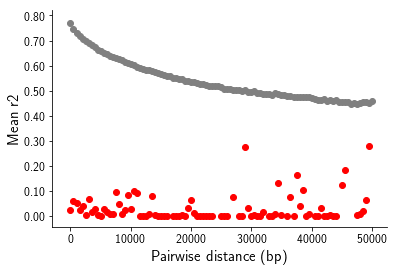

In [28]:
snpsnp["distbin"] = (snpsnp["distance"]/BINSIZE).apply(int)
snpsnp_bins = snpsnp.groupby("distbin", as_index=False).agg({"r2": np.mean})

snpstr["distbin"] = (snpstr["distance"].apply(abs)/BINSIZE).apply(int)
snpstr_bins = snpstr.groupby("distbin", as_index=False).agg({"r2": np.mean})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(snpsnp_bins["distbin"]*BINSIZE, snpsnp_bins["r2"], color="gray");
ax.scatter(snpstr_bins["distbin"]*BINSIZE, snpstr_bins["r2"], color="red");
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Pairwise distance (bp)", size=15)
ax.set_ylabel("Mean r2", size=15)
ax.set_xticklabels([int(x) for x in ax.get_xticks()], size=12)
ax.set_yticklabels(["%0.2f"%(x) for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "Figure2_SnpStrLD.pdf"))

# Figure 2B: Heterozygosity vs. best LD

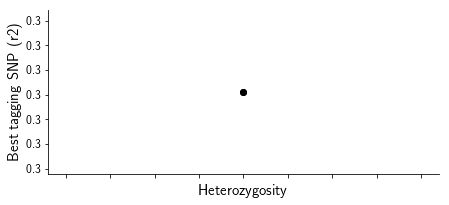

In [29]:
BINSIZE=0.1

fig = plt.figure()
fig.set_size_inches((7, 3))
ax = fig.add_subplot(111)
colors=["black"]

dfs = [snpstr_best]
for i in range(len(dfs)):
    x = dfs[i]
    c = colors[i]
    x["hetbin"] = x["het"].apply(lambda x: int(x/BINSIZE)*BINSIZE)
    x = x[x["hetbin"]>=0.1]
    means_all = x.groupby("hetbin", as_index=False).agg({"r2": mean})
    medians_all = x.groupby("hetbin", as_index=False).agg({"r2": median})
    ax.plot(means_all["hetbin"], means_all["r2"], color=c, marker="o")
    ax.plot(medians_all["hetbin"], medians_all["r2"], color=c, marker="o", linestyle="dashed")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel("Heterozygosity", size=15)
ax.set_ylabel("Best tagging SNP (r2)", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels(["%0.1f"%(x) for x in ax.get_yticks()], size=12);

# Figure 2C: SNP-SNP vs. SNP-STR LD using allele-r2 - TODO

# Figure 2D: Freq vs. LD - TODO

# Figure 2E: Example back mutation - TODO

# TODO
cluster to haplotype groups all together first
then plot ordered by hap group
PCA on SNPs to cluster first?

In [120]:
numhaps = 1916*2
colnames = ["pos","ref","alt"] + ["hap_%s"%i for i in range(numhaps)]
haplotype = pd.read_csv("/storage/mgymrek/ssc-imputation/snpstr-ld/example_haplotypes.tab", sep="\t",
                       names=colnames, usecols=range(len(colnames)))
# Annotate variant type
haplotype["vartype"] = haplotype.apply(lambda x: ["SNP","STR"][int(len(x["ref"])>1)], 1)

# Set index
haplotype.index = ["SNP_%s"%i for i in range(haplotype.shape[0]-1)] + ["STR"]

# Annotate MAF for SNPs
def GetMAF(x):
    if x["vartype"]=="STR": return 100
    else:
        hapcols = [item for item in x.keys() if "hap" in item]
        num_alt = sum(x[hapcols])
        num_total = len(x)-3
        return num_alt*1.0/num_total
haplotype["maf"] = haplotype.apply(GetMAF, 1)

# Annotate STR lengths
ref = haplotype[haplotype["vartype"]=="STR"]["ref"].values[0]
alt = haplotype[haplotype["vartype"]=="STR"]["alt"].values[0].split(",")
str_allele_lengths = [len(ref)] + [len(item) for item in alt]

for i in range(numhaps):
    col = "hap_%s"%i
    gtlen = str_allele_lengths[haplotype[haplotype["vartype"]=="STR"][col].values[0]]
    haplotype.loc["STR", col] = gtlen

In [121]:
# Filter and transpose
hapcols = colnames[3:]
haplotype_filt = haplotype[haplotype["maf"]>=0.1]
haplotype_filt = haplotype_filt[hapcols].transpose()
haplotype_filt = haplotype_filt.sort_values(by="STR")

In [ ]:
def ClusterRows(hapmatrix, nclusters=6):
    c = AgglomerativeClustering(n_clusters=min([hapmatrix.shape[0], nclusters]))
    labels = c.fit_predict(hapmatrix)
    idx = sorted([(labels[i], i) for i in range(hapmatrix.shape[0])])
    neworder = [item[1] for item in idx]
    return hapmatrix[neworder,:], neworder, [item[0] for item in idx]

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


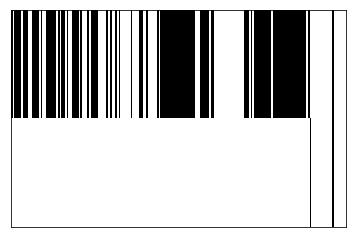

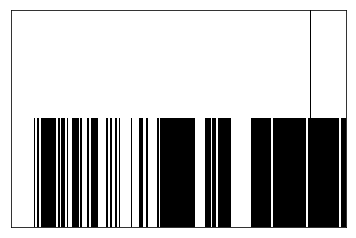

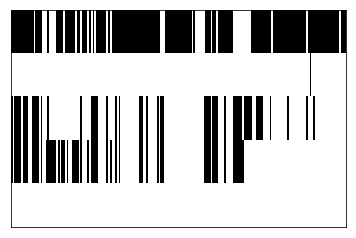

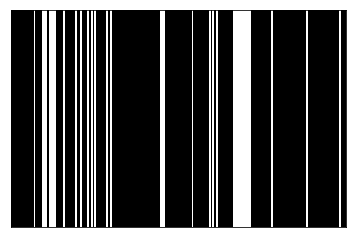

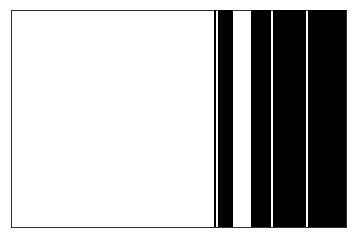

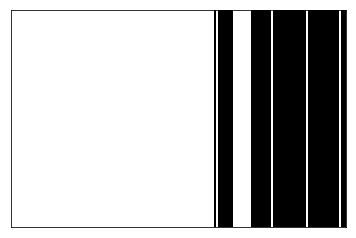

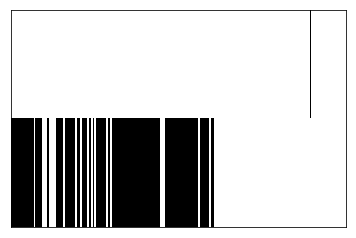

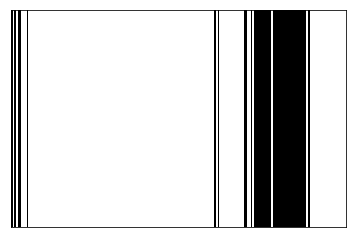

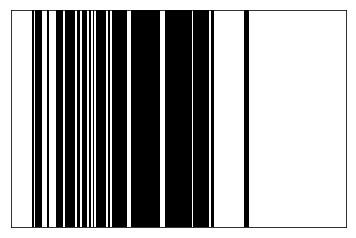

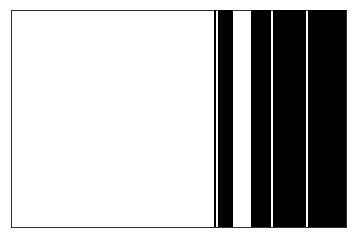

In [110]:
# Cluster and annotate haplotypes of entire dataset first
NCLUST=10
snpcols = [item for item in haplotype_filt.columns if "SNP" in item]
d = haplotype_filt[snpcols]
d_cl, neworder, clustids = ClusterRows(hapmatrix, nclusters=NCLUST)
haplotype_filt_reorder = haplotype_filt.iloc[neworder,]
haplotype_filt_reorder["cluster"] = clustids

# Vis all first to see clusters
for cnum in range(NCLUST):
    hapmatrix = np.matrix(haplotype_filt_reorder[haplotype_filt_reorder["cluster"]==cnum][snpcols])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(hapmatrix, cmap='Greys', aspect="auto", extent=(0, hapmatrix_cl.shape[1], 0, hapmatrix_cl.shape[0]))
    ax.set_yticks([]);
    ax.set_yticklabels([]);
    ax.set_xticks([]);
    ax.set_xticklabels([]);

In [101]:
haplotype_filt_reorder.head()

,SNP_2,SNP_7,SNP_8,SNP_13,SNP_15,SNP_16,SNP_18,SNP_21,SNP_35,SNP_36,...,SNP_995,SNP_998,SNP_999,SNP_1005,SNP_1020,SNP_1024,SNP_1026,SNP_1035,STR,cluster
hap_3136,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38,0
hap_99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38,0
hap_104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,38,0
hap_3443,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,43,0
hap_3508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,43,0


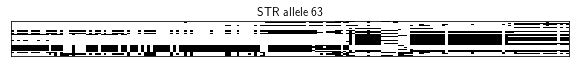

In [83]:
# SNP haplotypes per STR allele
for allele in [63]:
    d = haplotype_filt[haplotype_filt["STR"]==allele]
    hapmatrix = np.matrix(haplotype_filt_reorder[snpcols])
    fig = plt.figure()
    fig.set_size_inches((10, d.shape[0]*0.05))
    ax = fig.add_subplot(111)
    ax.imshow(hapmatrix_cl, cmap='Greys', aspect="auto", extent=(0, hapmatrix_cl.shape[1], 0, hapmatrix_cl.shape[0]))
    ax.set_yticks([]);
    ax.set_yticklabels([]);
    ax.set_xticks([]);
    ax.set_xticklabels([]);
    ax.set_title("STR allele %s"%allele)